# Saliency method evaluation using Performance Information Curve (PIC)

This notebook demonstrates the basic usage of pic.py module. The module can be used to compute metrics described in "XRAI: Better Attributions Through Regions" (1). For more detailed description see the documentation of the module inside saliency/metrics/pic.py.

(1) [https://arxiv.org/abs/1906.02825](https://arxiv.org/abs/1906.02825)

In [1]:
# Install dependencies if not installed already.
# !pip install matplotlib
# !pip install tensorflow

In [ ]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

# From our repository.
import saliency.core as saliency
from saliency.metrics import pic

### Utility methods

In [3]:
# Boilerplate methods.
def show_image(im, title='', ax=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(12, 6))
  ax.axis('off')
  ax.imshow(im)
  ax.set_title(title)


def show_grayscale_image(im, title='', ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')

  plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
  plt.title(title)


def show_curve_xy(x, y, title='PIC', label=None, color='blue',
    ax=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(12, 6))
  auc = np.trapz(y) / y.size
  label = f'{label}, AUC={auc:.3f}'
  ax.plot(x, y, label=label, color=color)
  ax.set_title(title)
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.0])
  ax.legend()


def show_curve(compute_pic_metric_result, title='PIC', label=None, color='blue',
    ax=None):
  show_curve_xy(compute_pic_metric_result.curve_x,
                compute_pic_metric_result.curve_y, title=title, label=label,
                color=color,
                ax=ax)


def show_blurred_images_with_scores(compute_pic_metric_result):
  # Get model prediction scores.
  images_to_display = compute_pic_metric_result.blurred_images
  scores = compute_pic_metric_result.predictions
  thresholds = compute_pic_metric_result.thresholds

  # Visualize blurred images.
  nrows = (len(images_to_display) - 1) // 5 + 1
  fig, ax = plt.subplots(nrows=nrows, ncols=5,
                         figsize=(20, 20 / 5 * nrows))
  for i in range(len(images_to_display)):
    row = i // 5
    col = i % 5
    title = f'score: {scores[i]:.3f}\nthreshold: {thresholds[i]:.3f}'
    show_image(images_to_display[i], title=title, ax=ax[row, col])


def load_image(file_path):
  im = PIL.Image.open(file_path)
  im = im.resize((224, 224))
  im = np.asarray(im)
  return im


def preprocess_image(im):
  im = tf.keras.applications.vgg16.preprocess_input(im)
  return im

### Loading the VGG16 model for ImageNet

In [ ]:
m = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
model = tf.keras.models.Model([m.inputs], [m.output])

In [5]:
class_idx_str = 'class_idx_str'


# The function needed for example saliency computation.
# It is not used in the metrics calculation.
def call_model_function(images, call_model_args=None, expected_keys=None):
  target_class_idx = call_model_args[class_idx_str]
  images = tf.convert_to_tensor(images)
  with tf.GradientTape() as tape:
    if expected_keys == [saliency.base.INPUT_OUTPUT_GRADIENTS]:
      tape.watch(images)
      output_layer = model(images)
      output_layer = output_layer[:, target_class_idx]
      gradients = np.array(tape.gradient(output_layer, images))
      return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}

### Load an image and infer

Prediction class: 236


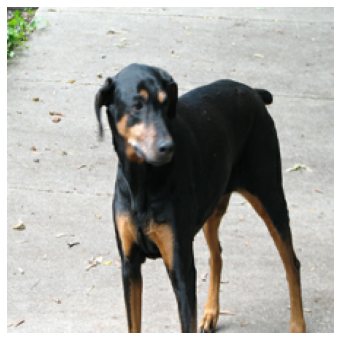

In [6]:
# Load the image
im_orig = load_image('./doberman.png')
im = preprocess_image(im_orig)

# Show the image
show_image(im_orig)

predictions = model(np.array([im]))
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

print("Prediction class: " + str(
    prediction_class))  # Should be a doberman, class idx = 236

### Compute saliency

In [ ]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
# We use Guided Integrated Gradients as an example saliency (see https://arxiv.org/abs/2106.09788).
guided_ig = saliency.GuidedIG()

# Baseline is a black image.
baseline = np.zeros(im.shape)

# Compute the Guided IG saliency.
guided_ig_mask_3d = guided_ig.GetMask(
    im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline,
    max_dist=1.0, fraction=0.5)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
guided_ig_mask_grayscale = saliency.VisualizeImageGrayscale(guided_ig_mask_3d)

# Plot the saliency result.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
show_image(im_orig, title='Original Image', ax=plt.subplot(ROWS, COLS, 1))
show_grayscale_image(guided_ig_mask_grayscale,
                     title='Guided Integrated Gradients',
                     ax=plt.subplot(ROWS, COLS, 2))

# Metrics

### Softmax Information Curve (SIC)

In [8]:
# Defines the fractions (thresholds) of top salient pixels for which the intermediate
# blurred images should be created and evaluated by the model. The higher the number of
# different thresholds is, the more accurate the PIC curve is.
saliency_thresholds = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.13,
                       0.21, 0.34, 0.5, 0.75]

# Saliency map to use for the metrics. Here we use the absolute value
# of the sum of attributions over the color channel.
gig_saliency_map = np.abs(np.sum(guided_ig_mask_3d, axis=2))

# Create a random mask for the initial fully blurred image.
random_mask = pic.generate_random_mask(image_height=im_orig.shape[0],
                                       image_width=im_orig.shape[1],
                                       fraction=0.01)


# Define prediction function.
def create_predict_function_softmax(class_idx):
  """Creates the model prediction function that can be passed to compute_pic_metric method.

    The function returns the softmax value for the Softmax Information Curve.
  Args:
    class_idx: the index of the class for which the model prediction should
      be returned.
  """

  def predict(image_batch):
    """Returns model prediction for a batch of images.

    The method receives a batch of images in uint8 format. The method is responsible to
    convert the batch to whatever format required by the model. In this particular
    implementation the conversion is achieved by calling preprocess_input().

    Args:
      image_batch: batch of images of dimension [B, H, W, C].

    Returns:
      Predictions of dimension [B].
    """
    image_batch = tf.keras.applications.vgg16.preprocess_input(image_batch)
    score = model(image_batch)[:, class_idx]
    return score.numpy()

  return predict


pred_func_sic = create_predict_function_softmax(prediction_class)

In [9]:
# Compute PIC for Guided IG.
try:
    gig_result_sic = pic.compute_pic_metric(img=im_orig,
                                            saliency_map=gig_saliency_map,
                                            random_mask=random_mask,
                                            pred_func=pred_func_sic,
                                            min_pred_value=0.5,
                                            saliency_thresholds=saliency_thresholds,
                                            keep_monotonous=True,
                                            num_data_points=1000)
except pic.ComputePicMetricError as e:
  # In normal circumstances skip the image. Here, we re-raise the error.
  raise e


# Don't forget to check for the None result.
if gig_result_sic is None:
  raise AssertionError(
      "The fully blurred image has same or higher score as compared to the original image.")

In [10]:
# For comparison, compute PIC for random saliency map.
rnd_saliency_map = np.random.random(size=(im_orig.shape[0], im_orig.shape[1]))
rnd_result_sic = pic.compute_pic_metric(img=im_orig,
                                        saliency_map=rnd_saliency_map,
                                        random_mask=random_mask,
                                        pred_func=pred_func_sic,
                                        min_pred_value=0.5,
                                        saliency_thresholds=saliency_thresholds,
                                        keep_monotonous=True,
                                        num_data_points=1000)



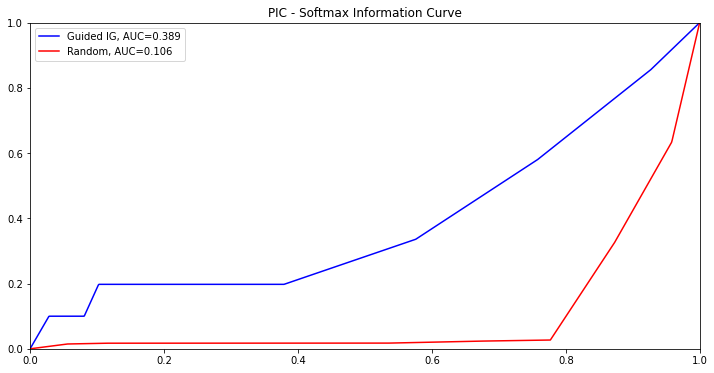

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
title = "PIC - Softmax Information Curve"
show_curve(gig_result_sic, title=title, label='Guided IG', color='blue', ax=ax)
show_curve(rnd_result_sic, title=title, label='Random', color='red', ax=ax)

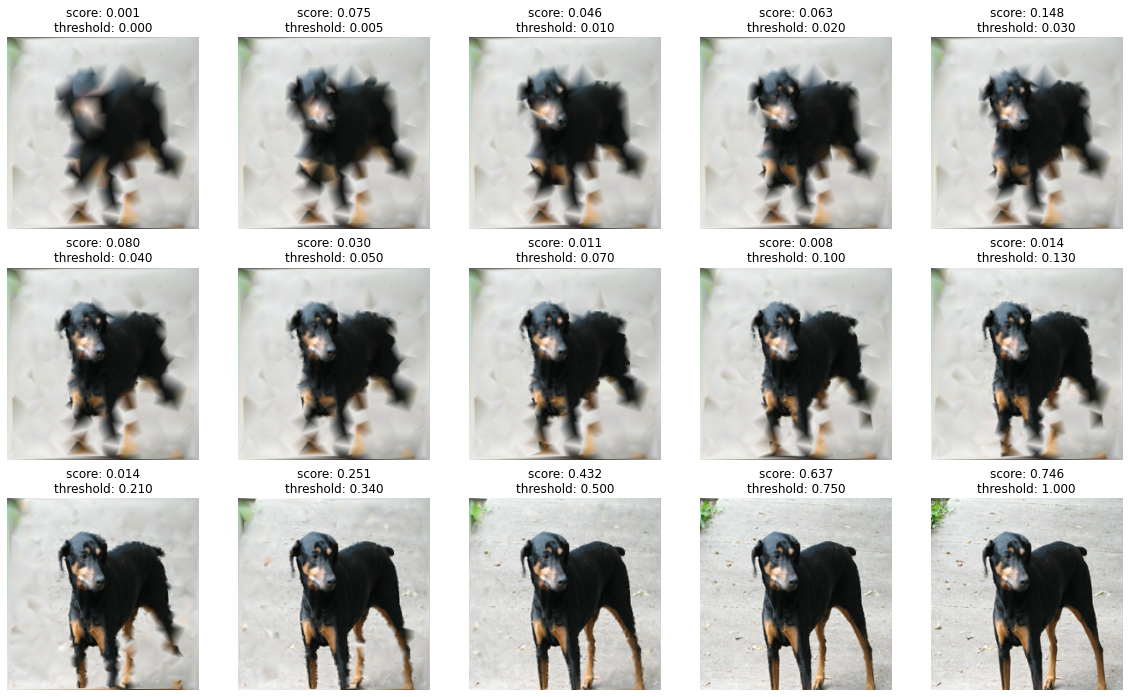

In [12]:
# Display blurred images and the prediction scores.
show_blurred_images_with_scores(gig_result_sic)

### Accuracy Information Curve (AIC)

The code for AIC is identical to the code for SIC except that the prediction function returns
accuracy (i.e. 1.0 or 0.0) instead of the softmax score.

In [13]:
# Define prediction function.
def create_predict_function_accuracy(class_idx):
  """Creates the model prediction function that can be passed to compute_pic_metric method.

    The function returns the accuracy for the Accuracy Information Curve.

  Args:
    class_idx: the index of the class for which the model prediction score should
      be returned.
  """

  def predict(image_batch):
    """Returns model accuracy for a batch of images.

    The method receives a batch of images in uint8 format. The method is responsible to
    convert the batch to whatever format required by the model. In this particular
    implementation the conversion is achieved by calling preprocess_input().

    Args:
      image_batch: batch of images of dimension [B, H, W, C].

    Returns:
      Predictions of dimension [B], where every element is either 1.0 for correct
      prediction or 0.0 for incorrect prediction.
    """
    image_batch = tf.keras.applications.vgg16.preprocess_input(image_batch)
    scores = model(image_batch)
    arg_max = np.argmax(scores, axis=1)
    accuracy = arg_max == class_idx
    return np.ones_like(arg_max) * accuracy

  return predict


pred_func_accuracy = create_predict_function_accuracy(prediction_class)

In [14]:
# Compute PIC for Guided IG.
try:
  gig_result_aic = pic.compute_pic_metric(img=im_orig,
                                          saliency_map=gig_saliency_map,
                                          random_mask=random_mask,
                                          pred_func=pred_func_accuracy,
                                          min_pred_value=0.5,
                                          saliency_thresholds=saliency_thresholds,
                                          keep_monotonous=True,
                                          num_data_points=1000)
except pic.ComputePicMetricError as e:
  # In normal circumstances skip the image. Here, we re-raise the error.
  raise e

# For comparison, compute PIC for random saliency map.
rnd_result_aic = pic.compute_pic_metric(img=im_orig,
                                        saliency_map=rnd_saliency_map,
                                        random_mask=random_mask,
                                        pred_func=pred_func_accuracy,
                                        min_pred_value=0.5,
                                        saliency_thresholds=saliency_thresholds,
                                        keep_monotonous=True,
                                        num_data_points=1000)

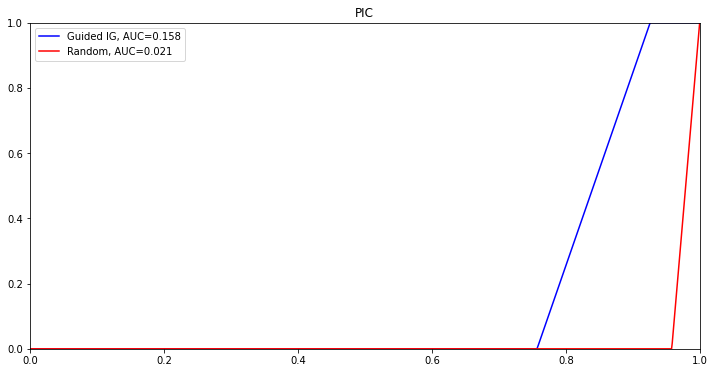

In [15]:
# Display the result
fig, ax = plt.subplots(figsize=(12, 6))
show_curve(gig_result_aic, label='Guided IG', color='blue', ax=ax)
show_curve(rnd_result_aic, label='Random', color='red', ax=ax)

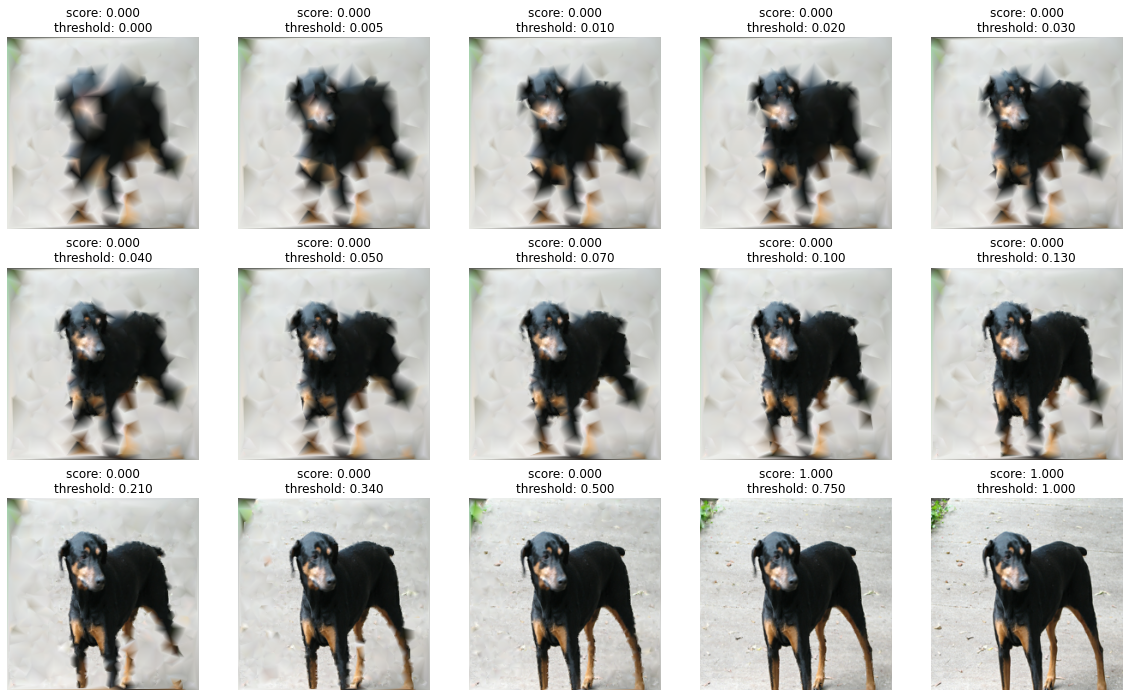

In [16]:
# Display blurred images and the prediction scores.
show_blurred_images_with_scores(gig_result_aic)

## Aggregate results (SIC)

In [17]:
# In a real situation, you will aggregate individual results that are obtained on different images.
# Here, we just repeat the result of the same doberman image multiple times.
gig_individual_results = [gig_result_sic, gig_result_sic, gig_result_sic]
gig_agg_result = pic.aggregate_individual_pic_results(
    compute_pic_metrics_results=gig_individual_results, method='median')

# Do the same for another saliency method. Here, we use results from the random saliency.
rnd_individual_results = [rnd_result_sic, rnd_result_sic, rnd_result_sic]
rnd_agg_result = pic.aggregate_individual_pic_results(
    compute_pic_metrics_results=rnd_individual_results, method='median')

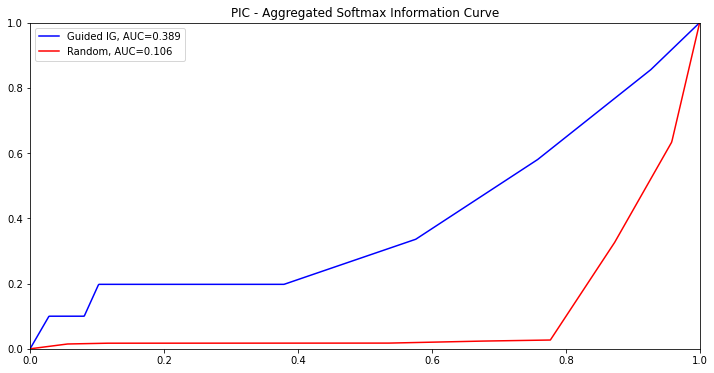

In [18]:
# Plot the aggregated curves. Since we used a single image, the curve should look
# identical to the single image result.
fig, ax = plt.subplots(figsize=(12, 6))
title = "PIC - Aggregated Softmax Information Curve"
show_curve_xy(gig_agg_result.curve_x, gig_agg_result.curve_y, title=title,
              label='Guided IG', color='blue', ax=ax)
show_curve_xy(rnd_agg_result.curve_x, rnd_agg_result.curve_y, title=title,
              label='Random', color='red', ax=ax)